![dsl logo](https://github.com/BrockDSL/ARCH_Data_Explore/blob/main/dsl_logo.png?raw=true)

# A notebook for displaying the sentiment scores of various municipalities

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact

In [ ]:
def download_file(url, filename=None, loud=True):
  
  if not filename:
    filename = url.split('/')[-1]
  
  r = requests.get(url, stream=True)
  if loud:
    total_bytes_dl = 0
    content_len = int(r.headers['Content-Length'])

  with open(filename, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=4096):
          fd.write(chunk)
          if loud:
            total_bytes_dl += 4096
            percent = int((total_bytes_dl / content_len) * 100.0)
            print(f'\rDownload progress of {filename} {total_bytes_dl}/{content_len}: {percent}%',end='')
  r.close()

def get_muni_data():
  download_file("https://brockau.s3.us-east-2.amazonaws.com/municipal_data.csv.gz")
  !gunzip -f municipal_data.csv.gz
  archive_data = pd.read_csv("municipal_data.csv")
  archive_data.drop(columns=['Unnamed: 0', 'index', 'v_pos','v_neg','v_neu', 'mime_type_web_server', 'mime_type_tika', 'language'], inplace=True)
  archive_data = archive_data[archive_data.content.notna()]
  archive_data.crawl_date = pd.to_datetime(archive_data.crawl_date)
  archive_data.content = archive_data.content.astype("string")
  return archive_data

r = requests.get('https://raw.githubusercontent.com/BrockDSL/ARCH_Data_Explore/main/urls_of_interest.txt')
urls_of_interest = r.text.split()

domains = [
"westlincoln.ca",
"thorold.ca",
"forterie.ca",
"welland.ca",
"niagararegion.ca",
"notl.com",
"wainfleet.ca",
"portcolborne.ca",
"grimsby.ca",
"lincoln.ca",
"pelham.ca",
"niagarafalls.ca",
"stcatharines.ca"]

#Retrieve data
data = get_muni_data()
data = data[data.content.notna()]
data = data[data.url.isin(urls_of_interest)].drop_duplicates(subset=['crawl_date','url','content'])
data = data.sort_values(by=['domain', 'crawl_date'])
data = data.set_index('domain')

Download progress of municipal_data.csv.gz 51339264/51335494: 100%

Text(0.5, 1.0, 'Mean Sentiment Scores by Domain 2020-04-08 - 2021-12-31')

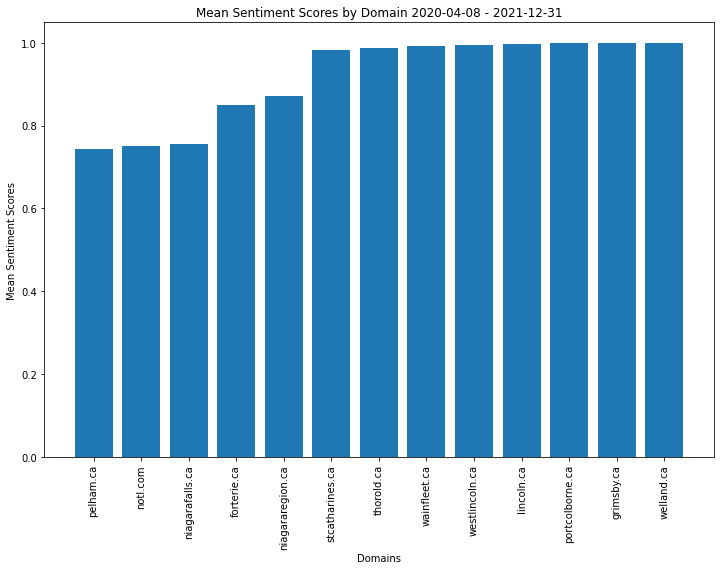

In [ ]:
barchart_data = data['v_comp'].groupby('domain').mean().sort_values()
fig, ax = plt.subplots(figsize=(12,8))
x_pos = range(len(barchart_data))
ax.bar(x_pos,barchart_data)
ax.set_xticks(x_pos)
ax.set_xticklabels(barchart_data.index.values, rotation=90)
ax.set_ylabel('Mean Sentiment Scores')
ax.set_xlabel('Domains')
ax.set_title('Mean Sentiment Scores by Domain 2020-04-08 - 2021-12-31')

In [ ]:
def plot_sentiment(domain):
    fig, ax = plt.subplots(figsize=(12,8))
    domain_data = data.loc[domain][['v_comp','crawl_date']].set_index('crawl_date').groupby(pd.Grouper(freq='1M')).mean()
    x_pos = range(len(domain_data))
    ax.plot(x_pos,domain_data.v_comp)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(domain_data.index.strftime('%Y-%m-%d'), rotation=90)
    ax.set_ylabel('Sentiment Scores')
    ax.set_title(f"{domain} Sentiment Scores")

    #Plot a horizontal line showing mean over entire period
    total_mean = data.loc[domain]['v_comp'].mean()
    tm_line = ax.plot(x_pos, [total_mean]*len(x_pos), label="Total Period Mean")
    ax.legend()

interact(plot_sentiment, domain=set(data.index));

interactive(children=(Dropdown(description='domain', options=('stcatharines.ca', 'westlincoln.ca', 'welland.ca…